In [1]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn import model_selection
from sklearn.metrics import r2_score

import numpy as np

1. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [2]:
# сгенерируем данные
X, y = datasets.make_regression(n_samples=100,
                                n_features=1,
                                n_informative=10,
                                n_targets=1,
                                noise=15,
                                random_state=21)

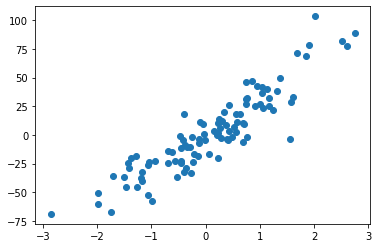

In [3]:
# визуализируем сгенерированные данные
plt.scatter(X, y)

In [4]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

        
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.labels.mean()

In [5]:
def criterion(labels):
    return labels.var()
  

# Расчет качества
def quality(left_labels, right_labels, current_criterion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)


# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


# Нахождение наилучшего разбиения
def find_best_split(data, labels, min_leaf):
    
    #  обозначим минимальное количество объектов в узле
            current_criterion = criterion(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, min_leaf = 5):

    quality, t, index = find_best_split(data, labels, min_leaf = min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


def predict_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return predict_object(obj, node.true_branch)
    else:
        return predict_object(obj, node.false_branch)

def predict(data, tree):
    
    y_pred = []
    for obj in data:
        prediction = predict_object(obj, tree)
        y_pred.append(prediction)
    return y_pred

In [6]:
# Разобьем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y, 
                                                                    test_size = 0.3,
                                                                    random_state = 21)

In [7]:
tree = build_tree(X_train, y_train)

In [8]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(tree)

Индекс 0
Порог 0.7646500833837553
--> True:
  Индекс 0
  Порог -0.45772322599444504
  --> True:
    Индекс 0
    Порог -1.4764421219954438
    --> True:
      Прогноз: -55.571988344293096
    --> False:
      Индекс 0
      Порог -1.053817305346984
      --> True:
        Прогноз: -33.302761746409956
      --> False:
        Прогноз: -22.26602193401343
  --> False:
    Индекс 0
    Порог -0.11608401835854118
    --> True:
      Индекс 0
      Порог -0.28522503958304174
      --> True:
        Прогноз: -8.557973442259655
      --> False:
        Прогноз: -14.280091353210189
    --> False:
      Индекс 0
      Порог 0.4027237912358534
      --> True:
        Индекс 0
        Порог 0.22075338645325868
        --> True:
          Прогноз: -0.7331894395770467
        --> False:
          Прогноз: 2.8562444719042874
      --> False:
        Индекс 0
        Порог 0.5737089363593981
        --> True:
          Прогноз: 10.33889103426114
        --> False:
          Прогноз: 9.68094445540953
-

In [9]:
# Получим ответы для обучающей и тестовой выборки 
train_answers = predict(X_train, tree)

answers = predict(X_test, tree)

In [10]:
#R2 для обучающей выборки
r2_score(train_answers, y_train)

0.8953963827921614

In [11]:
#R2 для тестовой выборки
r2_score(answers, y_test)

0.7042749411540942

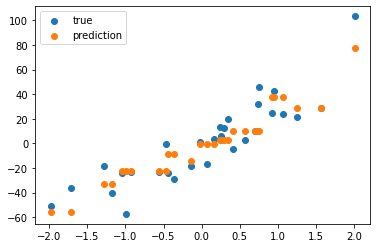

In [12]:
# визуализируем данные после их обработки моделькой
plt.scatter(X_test, y_test, label='true')
plt.scatter(X_test, answers, label='prediction')
plt.legend()